In [1]:
# mount gdrive
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# unzip data
!unzip -q "/content/gdrive/My Drive/TSAI/session5/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [1]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd
import os

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16

from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import GlobalAveragePooling2D, Dropout, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column

print("Shape: ", df.shape)
df.head(3)

Shape:  (13573, 9)


,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg


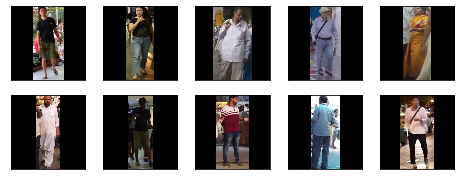

In [3]:
# visualize few images
fig = plt.figure(figsize=(8,3))
for i in range(10):
  ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
  img = image.load_img(df.image_path[i])
  plt.imshow(img)
plt.show()

In [0]:
# utility function to view image properties and its labeling
def viewData(index):
  img = image.load_img(df.image_path[index])
  plt.imshow(img)
  print(df.iloc[index])

gender                              male
imagequality                        Good
age                                25-35
weight                    normal-healthy
carryingbag     Grocery/Home/Plastic Bag
footwear                           Fancy
emotion                          Neutral
bodypose                  Front-Frontish
image_path              resized/4865.jpg
Name: 4864, dtype: object


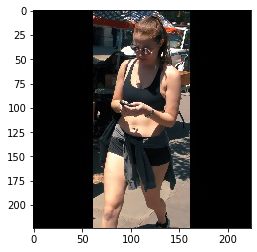

In [5]:
viewData(4864) # typical case of wrong labeling (Gender is wrongly labeled)

In [6]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

# view one-hot encoding results
one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, data_augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.data_augmentation = data_augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])

        # normalize the data
        image = image.astype('float32') / 255

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }

        #image = self.data_augmentation.flow(image, shuffle=False).next()

        if self.data_augmentation is not None:
            self.data_augmentation.fit(image)
            image = self.data_augmentation.flow(image, shuffle=False).next()

        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [8]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
def cutout_fxn(img):

    height = img.shape[0]
    width = img.shape[1]
    depth = img.shape[2]

    CUT_SIZE = 32 #height//4

    img_new = np.zeros((width+2*CUT_SIZE,height+2*CUT_SIZE, depth), np.float32)

    # normalize before adding the mask
    #mean = img.mean(keepdims=True)
    mean = np.mean(img, axis=(0, 1))
    img -= mean

    img_new[CUT_SIZE:width+CUT_SIZE,CUT_SIZE:height+CUT_SIZE,:] = img
    #print(mean)

    mask = np.ones((width+2*CUT_SIZE,height+2*CUT_SIZE,depth), np.float32)

    # after analysing the few images it is found that actual pictures are
    # at center of the image so cutout to be position accordingly
    offset = 50
 
    y1 = np.random.randint(height+CUT_SIZE)
    y2 = y1 + CUT_SIZE
    x1 = np.random.randint(offset, width+CUT_SIZE-offset)
    x2 = x1 + CUT_SIZE

    mask[y1: y2, x1: x2,:] = 0

    # apply mask
    img_new = img_new * mask

    # denormalize
    img_new += mean

    final_img = img_new[CUT_SIZE:width+CUT_SIZE,CUT_SIZE:height+CUT_SIZE,:]

    return final_img

def lr_schedule(epoch, lr):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after each epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = round(0.0001 * 1/(1 + 0.001 * epoch), 10)
    return lr

In [0]:
# applying data augmentation
datagen = ImageDataGenerator(
        # randomly flip images
        horizontal_flip=True,
        # set function that will be applied on each input
        preprocessing_function=cutout_fxn
    )

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, data_augmentation = datagen)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [12]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

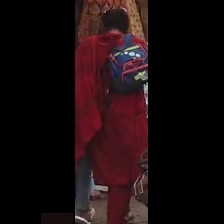

In [13]:
cv2_imshow(images[10]*255)

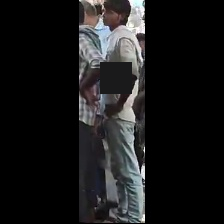

In [14]:
cv2_imshow(images[20]*255)

In [15]:
backbone = VGG16(
    weights=None, #weights="imagenet", 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.5)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.5)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# # freeze backbone
# for layer in backbone.layers:
# 	layer.trainable = False

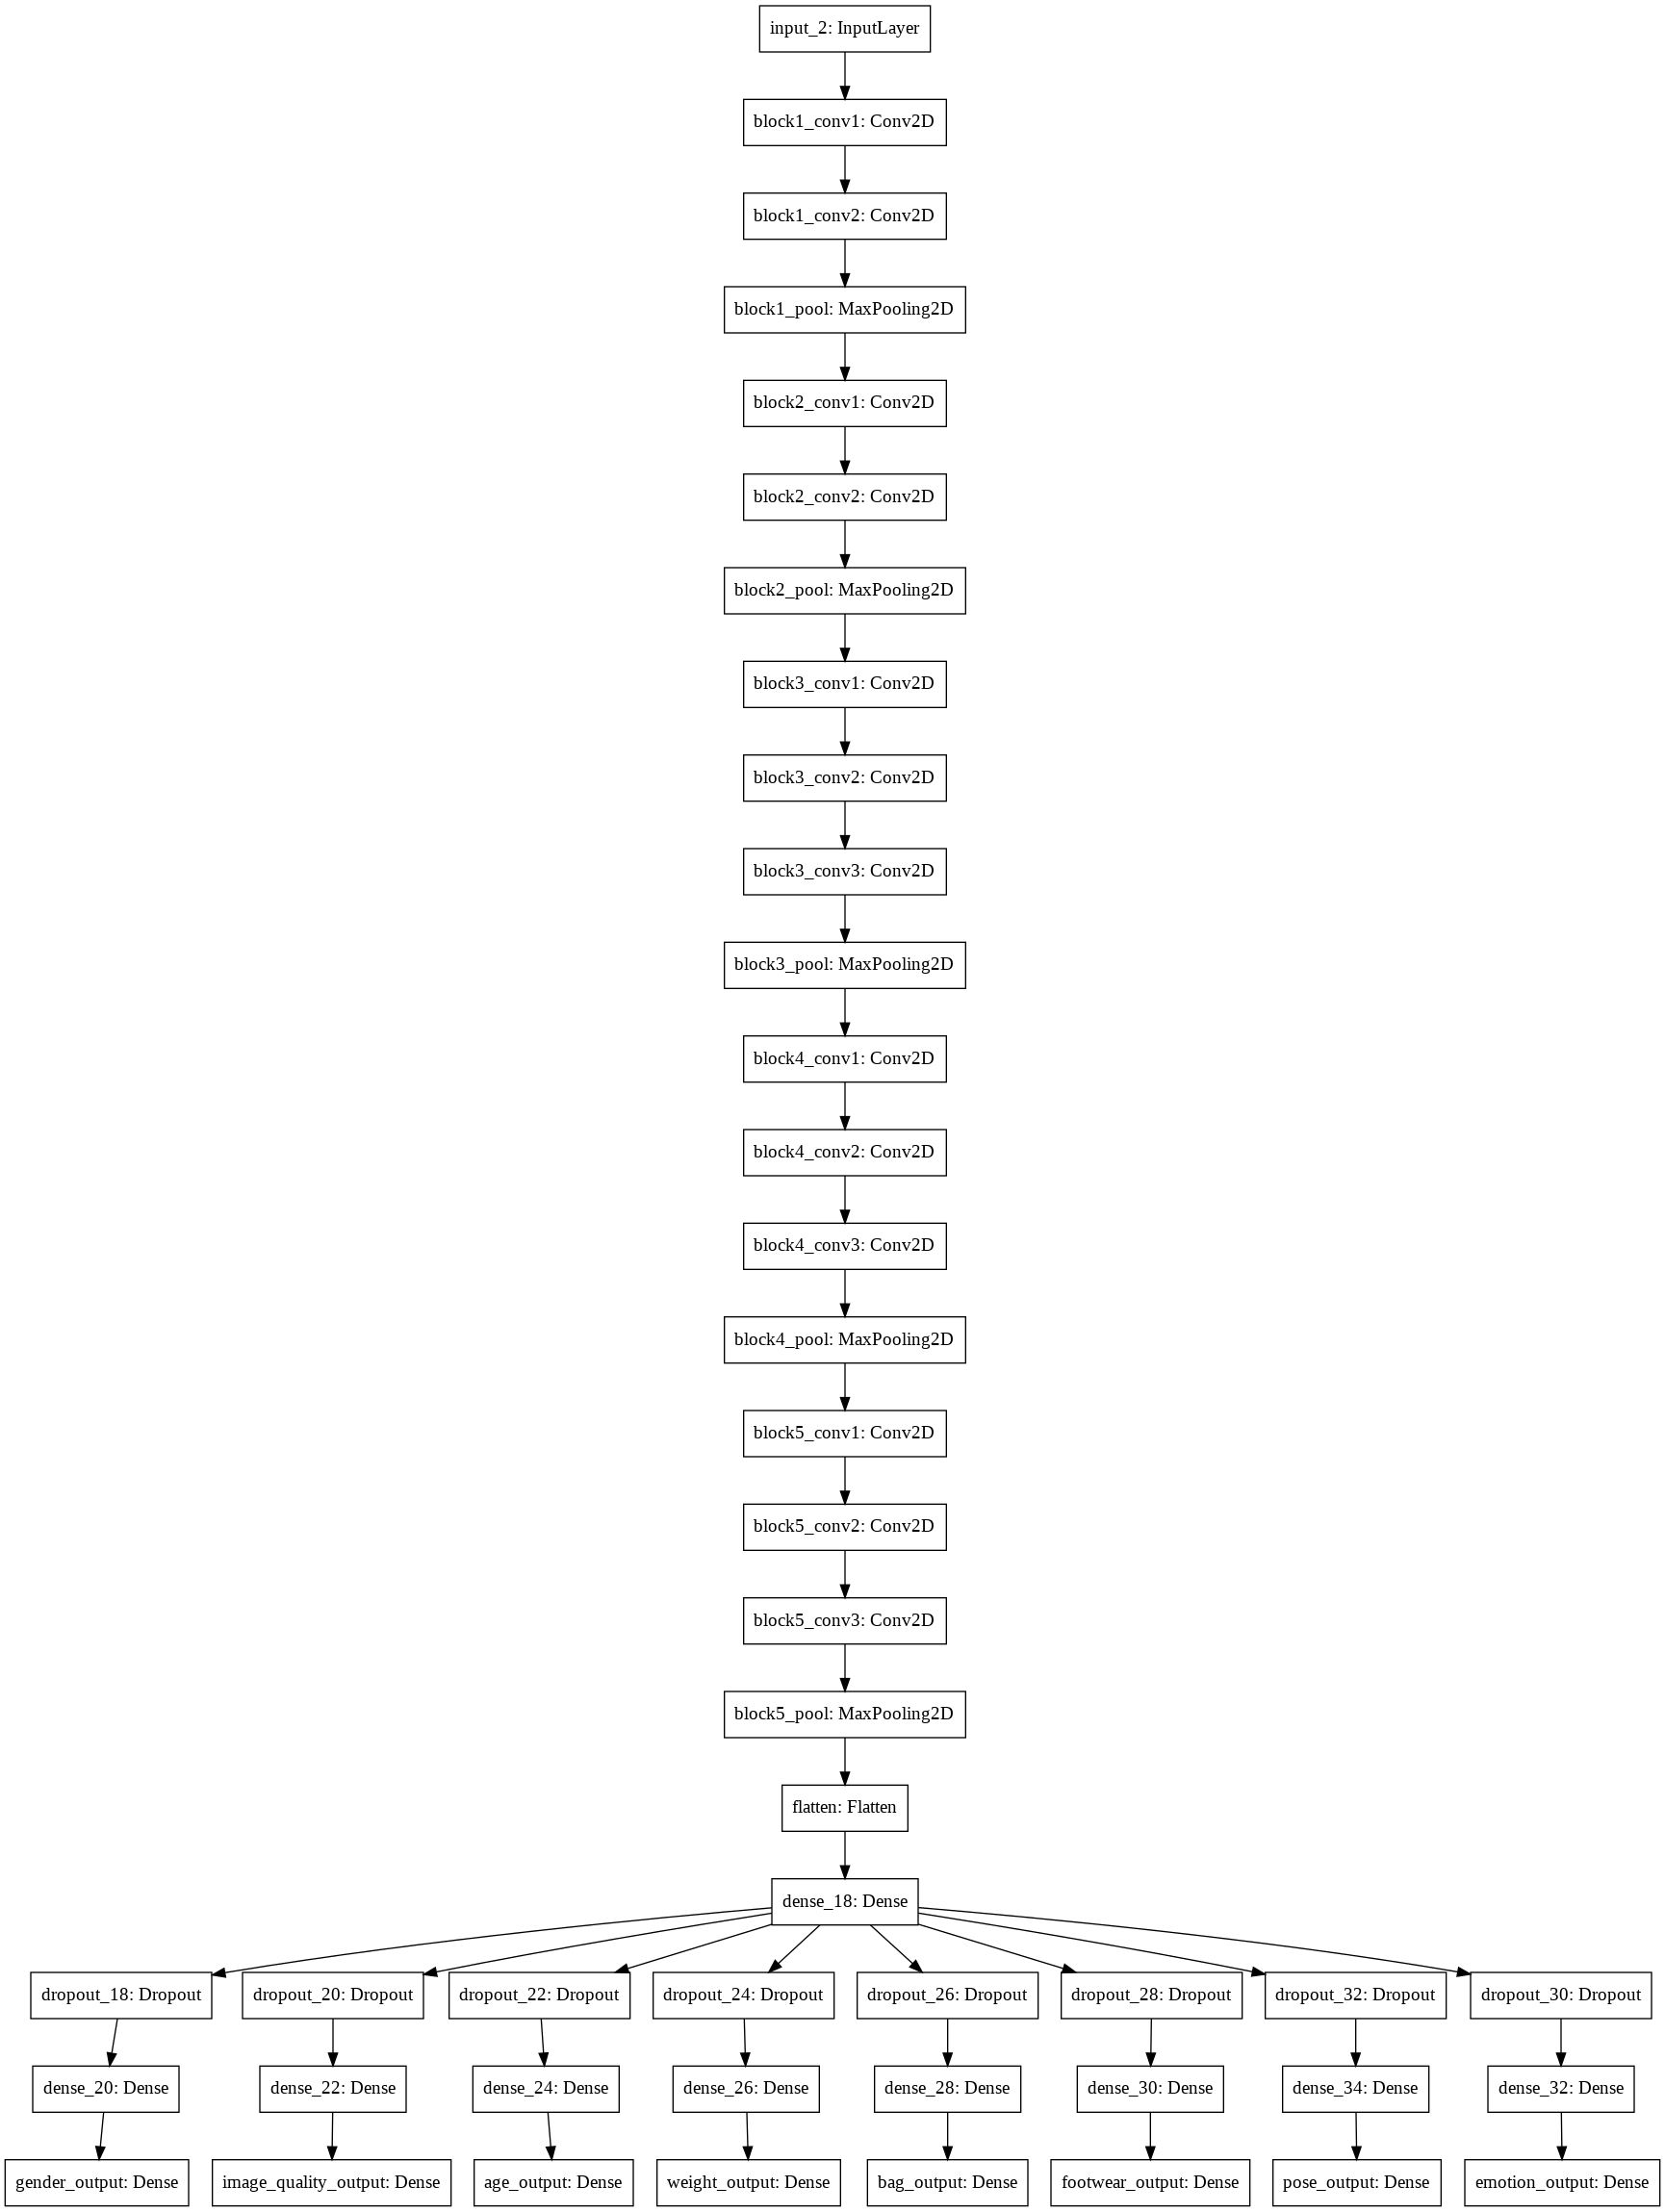

In [21]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, to_file='model_plot.png', show_layer_names=True)

In [22]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [0]:
losses = {
 	"gender_output": "binary_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
 	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy",
 }

loss_weights = {
 	"gender_output": 1.0,
 	"image_quality_output": 1.0,
 	"age_output": 1.0,
 	"weight_output": 1.0,
  "bag_output": 1.0,
  "footwear_output": 1.0,
  "pose_output": 1.0,
  "emotion_output": 1.0,
 }


opt = SGD(lr=0.0004, momentum=0.9)
model.compile(
    optimizer=opt,
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_model8')
#model_name = 'person_model_best.h5'
model_name = 'person_model.{epoch:03d}.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=2, #patience=5
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_scheduler]

In [25]:
history = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=20,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
360/360 [==============================] - 114s 316ms/step - loss: 6.0244 - gender_output_loss: 0.3105 - image_quality_output_loss: 0.9207 - age_output_loss: 1.2548 - weight_output_loss: 0.8646 - bag_output_loss: 0.7538 - footwear_output_loss: 0.6860 - pose_output_loss: 0.4120 - emotion_output_loss: 0.8219 - gender_output_acc: 0.8681 - image_quality_output_acc: 0.5682 - age_output_acc: 0.4498 - weight_output_acc: 0.6580 - bag_output_acc: 0.6753 - footwear_output_acc: 0.7028 - pose_output_acc: 0.8372 - emotion_output_acc: 0.7160 - val_loss: 5.5850 - val_gender_output_loss: 0.2532 - val_image_quality_output_loss: 0.8950 - val_age_output_loss: 1.1860 - val_weight_output_loss: 0.8191 - val_bag_output_loss: 0.6770 - val_footwear_output_loss: 0.6312 - val_pose_output_loss: 0.3045 - val_emotion_output_loss: 0.8191 - val_gender_output_acc: 0.9017 - val_image_quality_output_acc: 0.5756 - val_age_output_acc: 0.5045 -

In [0]:
from keras.models import load_model
best_model = load_model("/content/saved_model8/person_model.008.h5")

In [28]:
# Evaluate Model for test data
results = best_model.evaluate_generator(valid_gen, verbose=1)
results_dict = dict(zip(best_model.metrics_names, results))

31/31 [==============================] - 6s 190ms/step


In [29]:
# get accuracies for each category
acc_results = {name:result for name, result in zip(best_model.metrics_names, results) if name.endswith("acc")}
print("Total Validation Loss: ", results_dict['loss'])
print("Validation Accuracies: ")
acc_results

Total Validation Loss:  5.317631198513892
Validation Accuracies: 


{'age_output_acc': 0.5206653225806451,
 'bag_output_acc': 0.734375,
 'emotion_output_acc': 0.7096774193548387,
 'footwear_output_acc': 0.7409274193548387,
 'gender_output_acc': 0.9198588709677419,
 'image_quality_output_acc': 0.5871975806451613,
 'pose_output_acc': 0.9117943548387096,
 'weight_output_acc': 0.7036290322580645}